# Imports

In [ ]:
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error
from typing import Optional, List, Union, Tuple, Dict
from tabulate import tabulate
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Border, Side, Alignment, Font
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import Rule, ColorScale, FormatObject
from openpyxl.utils import get_column_letter



#Sorting Data

In [ ]:
# Read the CSV file
input_path = '/root/alpha_complete.csv'
output_path = '/root/alpha_complete_Sorted.csv'

# Check if the input file exists
if not os.path.exists(input_path):
    print(f"Error: Input file not found at {input_path}")
    exit(1)

# Read the CSV file
df = pd.read_csv(input_path)

# Convert subject names to lowercase for consistent sorting
df['subject'] = df['subject'].str.lower()

# Sort the dataframe
sorted_df = df.sort_values(by=['subject', 'behavior', 'box', 'observed', 'session', 'start'])

# Reset the index
sorted_df = sorted_df.reset_index(drop=True)

# Save the sorted dataframe to a new CSV file
sorted_df.to_csv(output_path, index=False)

print(f"Sorted data has been saved to {output_path}")

Sorted data has been saved to /root/alpha_complete_Sorted.csv


# Order the data in a tensor object for future calculations and Plots

In [ ]:
# Read the CSV file
df = pd.read_csv('/root/alpha_complete_Sorted.csv')

# Identify unique subjects, box colors, behaviors, and sessions
subjects = df['subject'].unique()
box_colors = df['box'].dropna().unique()
animals = subjects.copy()
sessions = np.sort(df['session'].unique())

# Create a list of all behaviors
behaviors = (
    [f'exploring_{color}' for color in box_colors] +
    [f'manipulating_{color}' for color in box_colors] +
    [f'looking at_{animal}' for animal in animals]
)

# Create a dictionary to map behaviors to indices
behavior_to_index = {behavior: i for i, behavior in enumerate(behaviors)}

# Find the maximum session duration
max_session_duration = 0
for session in sessions:
    session_data = df[df['session'] == session]
    session_duration = session_data['stop'].max() - session_data['start'].min()
    max_session_duration = max(max_session_duration, session_duration)

max_session_seconds = int(np.ceil(max_session_duration))

# Initialize a numpy array to hold the data
# Dimensions: [subjects, behaviors, sessions, time, data_type]
# data_type: [0] = state, [1] = successful attempt, [2] = unsuccessful attempt
data_array = np.zeros((len(subjects), len(behaviors), len(sessions), max_session_seconds, 3), dtype=np.float32)

# Fill the array with behavior data and attempts
for session in sessions:
    session_data = df[df['session'] == session]
    session_start = session_data['start'].min()

    # Fill continuous state behaviors
    state_data = session_data[session_data['behavior type'] == 'STATE']
    for _, row in state_data.iterrows():
        subject = row['subject']
        behavior = row['behavior']
        box = row['box']
        observed = row['observed']
        start = int(row['start'] - session_start)
        stop = int(row['stop'] - session_start)

        subject_index = np.where(subjects == subject)[0][0]
        session_index = np.where(sessions == session)[0][0]

        if behavior == 'exploring' or behavior == 'manipulating':
            behavior_index = behavior_to_index.get(f'{behavior}_{box}')
        elif behavior == 'looking at':
            behavior_index = behavior_to_index.get(f'{behavior}_{observed}')
        else:
            continue

        if behavior_index is not None:
            data_array[subject_index, behavior_index, session_index, start:stop, 0] = 1

    # Process POINT behaviors (attempts)
    attempt_data = session_data[session_data['behavior type'] == 'POINT']
    for _, row in attempt_data.iterrows():
        subject = row['subject']
        behavior = row['behavior']
        box = row['box']
        observed = row['observed']
        time_point = int(row['start'] - session_start)
        is_successful = behavior == 'successful'

        # Get array indices
        subject_index = np.where(subjects == subject)[0][0]

        # Handle all possible behaviors, not just manipulation
        if box is not None:  # Box-related attempts
            for action in ['exploring', 'manipulating']:
                behavior_index = behavior_to_index.get(f'{action}_{box}')
                if behavior_index is not None:
                    channel = 1 if is_successful else 2
                    data_array[subject_index, behavior_index, session_index, time_point, channel] = 1

        if observed is not None:  # Looking-at attempts
            behavior_index = behavior_to_index.get(f'looking at_{observed}')
            if behavior_index is not None:
                channel = 1 if is_successful else 2
                data_array[subject_index, behavior_index, session_index, time_point, channel] = 1

# Convert to PyTorch tensor and add attributes
behavior_tensor = torch.from_numpy(data_array)
behavior_tensor.subjects = subjects
behavior_tensor.behaviors = behaviors
behavior_tensor.sessions = sessions

print("Data array shape:", behavior_tensor.shape)
print("\nDimensions:")
print("- Subjects:", len(subjects))
print("- Behaviors:", len(behaviors))
print("- Sessions:", len(sessions))
print("- Time points:", max_session_seconds)
print("- Data types: 3 (state, successful attempts, unsuccessful attempts)")



Data array shape: torch.Size([6, 14, 10, 1098, 3])

Dimensions:
- Subjects: 6
- Behaviors: 14
- Sessions: 10
- Time points: 1098
- Data types: 3 (state, successful attempts, unsuccessful attempts)


# Analyze Data

### Find where "Point" states lie

In [ ]:
#DEFINITION OF BEING DUMB AND NOT KNOWING HOW TO DO THINGS. Just take the inner product element wise and count indices
#For that, Make the data into arrays already
#only after Neda you do Neda's task

def analyze_point_state_overlaps(df: pd.DataFrame) -> Dict:
    """
    Analyze overlaps between POINT behaviors (attempts) and STATE behaviors,
    showing exactly where successful and unsuccessful attempts occur
    """
    results = {}

    # Get point and state behaviors
    points_df = df[df['behavior type'] == 'POINT'].copy()
    states_df = df[df['behavior type'] == 'STATE'].copy()

    # Process each subject
    for subject, subject_data in states_df.groupby('subject'):
        subject_results = {
            'total_points': {
                'successful': 0,
                'unsuccessful': 0
            },
            'sessions': {}
        }

        # Process each session
        for session, session_states in subject_data.groupby('session'):
            session_points = points_df[
                (points_df['subject'] == subject) &
                (points_df['session'] == session)
            ]

            session_results = {
                'points': {
                    'successful': {
                        'total': 0,
                        'overlaps': {
                            'exploring': 0,
                            'manipulating': 0,
                            'looking at': {},  # Will store by observed subject
                            'scrounging': 0,
                            'no_overlap': 0
                        }
                    },
                    'unsuccessful': {
                        'total': 0,
                        'overlaps': {
                            'exploring': 0,
                            'manipulating': 0,
                            'looking at': {},  # Will store by observed subject
                            'scrounging': 0,
                            'no_overlap': 0
                        }
                    }
                }
            }

            # Process each point event
            for _, point in session_points.iterrows():
                point_type = 'successful' if point['behavior'] == 'successful' else 'unsuccessful'
                session_results['points'][point_type]['total'] += 1
                subject_results['total_points'][point_type] += 1

                # Find overlapping states
                overlapping_states = session_states[
                    (session_states['start'] <= point['start']) &
                    (session_states['stop'] >= point['stop'])
                ]

                if len(overlapping_states) == 0:
                    session_results['points'][point_type]['overlaps']['no_overlap'] += 1
                else:
                    for _, state in overlapping_states.iterrows():
                        if state['behavior'] == 'looking at':
                            # Track looking behavior by observed subject
                            observed = state['observed']
                            if observed not in session_results['points'][point_type]['overlaps']['looking at']:
                                session_results['points'][point_type]['overlaps']['looking at'][observed] = 0
                            session_results['points'][point_type]['overlaps']['looking at'][observed] += 1
                        else:
                            session_results['points'][point_type]['overlaps'][state['behavior']] += 1

            subject_results['sessions'][session] = session_results

        results[subject] = subject_results

    return results

def print_point_state_analysis(results: Dict):
    """Print formatted analysis of point-state overlaps"""
    for subject, subject_data in results.items():
        print(f"\n{subject.upper()}")
        print("=" * len(subject))

        total_successful = subject_data['total_points']['successful']
        total_unsuccessful = subject_data['total_points']['unsuccessful']

        print(f"\nTotal Points: {total_successful + total_unsuccessful}")
        print(f"Successful: {total_successful}")
        print(f"Unsuccessful: {total_unsuccessful}")

        # Process each session
        for session, session_data in subject_data['sessions'].items():
            if (session_data['points']['successful']['total'] +
                session_data['points']['unsuccessful']['total']) == 0:
                continue

            print(f"\nSession {session}")
            print("-" * 20)

            # Create tables for successful and unsuccessful points
            for point_type in ['successful', 'unsuccessful']:
                points_data = session_data['points'][point_type]
                if points_data['total'] == 0:
                    continue

                print(f"\n{point_type.capitalize()} Points")
                print(f"Total: {points_data['total']}")

                # Create overlap table
                overlap_table = []

                # Add regular state overlaps
                for state in ['exploring', 'manipulating', 'scrounging']:
                    if points_data['overlaps'][state] > 0:
                        percentage = (points_data['overlaps'][state] /
                                   points_data['total'] * 100)
                        overlap_table.append([
                            state,
                            points_data['overlaps'][state],
                            f"{percentage:.1f}%"
                        ])

                # Add looking at overlaps by subject
                for observed, count in points_data['overlaps']['looking at'].items():
                    percentage = (count / points_data['total'] * 100)
                    overlap_table.append([
                        f"looking at {observed}",
                        count,
                        f"{percentage:.1f}%"
                    ])

                # Add no overlap count
                if points_data['overlaps']['no_overlap'] > 0:
                    percentage = (points_data['overlaps']['no_overlap'] /
                               points_data['total'] * 100)
                    overlap_table.append([
                        "no overlap",
                        points_data['overlaps']['no_overlap'],
                        f"{percentage:.1f}%"
                    ])

                if overlap_table:
                    print("\nState overlaps:")
                    print(tabulate(overlap_table,
                                 headers=['State', 'Count', '% of Points'],
                                 tablefmt='grid'))

def main():
    # Load and process data
    df = pd.read_csv('/root/alpha_complete_Sorted.csv')

    # Analyze point-state overlaps
    results = analyze_point_state_overlaps(df)

    # Print results
    print_point_state_analysis(results)

if __name__ == "__main__":
    main()


FLOREANA

Total Points: 0
Successful: 0
Unsuccessful: 0

GENOVESA

Total Points: 58
Successful: 26
Unsuccessful: 32

Session 1
--------------------

Successful Points
Total: 3

State overlaps:
+--------------+---------+---------------+
| State        |   Count | % of Points   |
+==============+=========+===============+
| manipulating |       3 | 100.0%        |
+--------------+---------+---------------+

Unsuccessful Points
Total: 6

State overlaps:
+--------------+---------+---------------+
| State        |   Count | % of Points   |
+==============+=========+===============+
| manipulating |       6 | 100.0%        |
+--------------+---------+---------------+

Session 2
--------------------

Unsuccessful Points
Total: 3

State overlaps:
+--------------+---------+---------------+
| State        |   Count | % of Points   |
+==============+=========+===============+
| manipulating |       3 | 100.0%        |
+--------------+---------+---------------+

Session 3
--------------------

Un

###Check whether actions are mutually exclusive

In [ ]:
def analyze_behavior_times_and_overlaps(df: pd.DataFrame):
    """
    Analyze total time spent in each behavior type and overlaps between behaviors,
    broken down by subject and session.
    """
    # Initialize results dictionary
    results = {}

    # Group by subject
    for subject, subject_data in df.groupby('subject'):
        subject_results = {
            'overall': {'times': defaultdict(float), 'overlaps': defaultdict(float)},
            'sessions': {}
        }

        # Process each session
        for session, session_data in subject_data.groupby('session'):
            session_results = {
                'times': defaultdict(float),
                'overlaps': defaultdict(float)
            }

            # Calculate total time for each behavior type
            states = session_data[session_data['behavior type'] == 'STATE']
            for _, row in states.iterrows():
                behavior = row['behavior']
                duration = row['stop'] - row['start']
                session_results['times'][behavior] += duration
                subject_results['overall']['times'][behavior] += duration

            # Calculate overlaps between behaviors
            behaviors = sorted(session_results['times'].keys())
            for i, beh1 in enumerate(behaviors):
                for beh2 in behaviors[i+1:]:
                    beh1_data = states[states['behavior'] == beh1]
                    beh2_data = states[states['behavior'] == beh2]

                    overlap_time = 0
                    for _, row1 in beh1_data.iterrows():
                        for _, row2 in beh2_data.iterrows():
                            # Calculate overlap
                            overlap_start = max(row1['start'], row2['start'])
                            overlap_end = min(row1['stop'], row2['stop'])
                            if overlap_end > overlap_start:
                                overlap_time += overlap_end - overlap_start

                    pair_name = f"{beh1}_x_{beh2}"
                    session_results['overlaps'][pair_name] = overlap_time
                    subject_results['overall']['overlaps'][pair_name] += overlap_time

            subject_results['sessions'][session] = session_results

        results[subject] = subject_results

    return results

def print_analysis(results):
    """Print the analysis results in a formatted way"""
    for subject, subject_data in results.items():
        print(f"\n{subject.upper()}")
        print("=" * len(subject))

        # Print overall subject statistics
        print("\nOVERALL STATISTICS")
        print("-----------------")

        # Total time in each behavior
        times_table = [
            [behavior, f"{seconds:.1f}"]
            for behavior, seconds in subject_data['overall']['times'].items()
        ]
        print("\nTotal time in each behavior type:")
        print(tabulate(times_table, headers=['Behavior', 'Seconds'],
                      tablefmt='grid'))

        # Overall overlap times and percentages
        overlap_table = []
        for pair, overlap_seconds in subject_data['overall']['overlaps'].items():
            beh1, beh2 = pair.split('_x_')
            shorter_time = min(subject_data['overall']['times'][beh1],
                             subject_data['overall']['times'][beh2])
            if shorter_time > 0:
                percentage = (overlap_seconds / shorter_time) * 100
                overlap_table.append([
                    pair.replace('_x_', ' x '),
                    f"{overlap_seconds:.1f}",
                    f"{percentage:.1f}%"
                ])
            else:
                overlap_table.append([
                    pair.replace('_x_', ' x '),
                    f"{overlap_seconds:.1f}",
                    "nan%"
                ])

        print("\nOverall overlap times and percentages:")
        print(tabulate(overlap_table,
                      headers=['Behavior Pair', 'Overlap Seconds',
                              '% of Shorter Behavior'],
                      tablefmt='grid'))

        # Print session-by-session breakdown
        print("\nSESSION BREAKDOWN")
        print("----------------")

        for session, session_data in subject_data['sessions'].items():
            if not session_data['times']:  # Skip sessions with no data
                continue

            print(f"\nSession {session}:")

            # Session-specific times
            session_times_table = [
                [behavior, f"{seconds:.1f}"]
                for behavior, seconds in session_data['times'].items()
            ]
            print("\nBehavior times:")
            print(tabulate(session_times_table,
                         headers=['Behavior', 'Seconds'],
                         tablefmt='grid'))

            # Session-specific overlaps
            session_overlap_table = []
            for pair, overlap_seconds in session_data['overlaps'].items():
                beh1, beh2 = pair.split('_x_')
                shorter_time = min(session_data['times'][beh1],
                                 session_data['times'][beh2])
                if shorter_time > 0:
                    percentage = (overlap_seconds / shorter_time) * 100
                    session_overlap_table.append([
                        pair.replace('_x_', ' x '),
                        f"{overlap_seconds:.1f}",
                        f"{percentage:.1f}%"
                    ])
                else:
                    session_overlap_table.append([
                        pair.replace('_x_', ' x '),
                        f"{overlap_seconds:.1f}",
                        "nan%"
                    ])

            print("\nOverlap times and percentages:")
            print(tabulate(session_overlap_table,
                         headers=['Behavior Pair', 'Overlap Seconds',
                                 '% of Shorter Behavior'],
                         tablefmt='grid'))

def main():
    # Load and process data
    df = pd.read_csv('/root/alpha_complete_Sorted.csv')

    # Analyze data
    results = analyze_behavior_times_and_overlaps(df)

    # Print results
    print_analysis(results)

if __name__ == "__main__":
    main()


FLOREANA

OVERALL STATISTICS
-----------------

Total time in each behavior type:
+------------+-----------+
| Behavior   |   Seconds |
+============+===========+
| exploring  |     481.5 |
+------------+-----------+
| looking at |     259   |
+------------+-----------+

Overall overlap times and percentages:
+------------------------+-------------------+-------------------------+
| Behavior Pair          |   Overlap Seconds | % of Shorter Behavior   |
+========================+===================+=========================+
| exploring x looking at |              58.4 | 22.5%                   |
+------------------------+-------------------+-------------------------+

SESSION BREAKDOWN
----------------

Session 1:

Behavior times:
+------------+-----------+
| Behavior   |   Seconds |
+============+===========+
| exploring  |      91.5 |
+------------+-----------+
| looking at |       2.4 |
+------------+-----------+

Overlap times and percentages:
+------------------------+-----------

# Plot the data

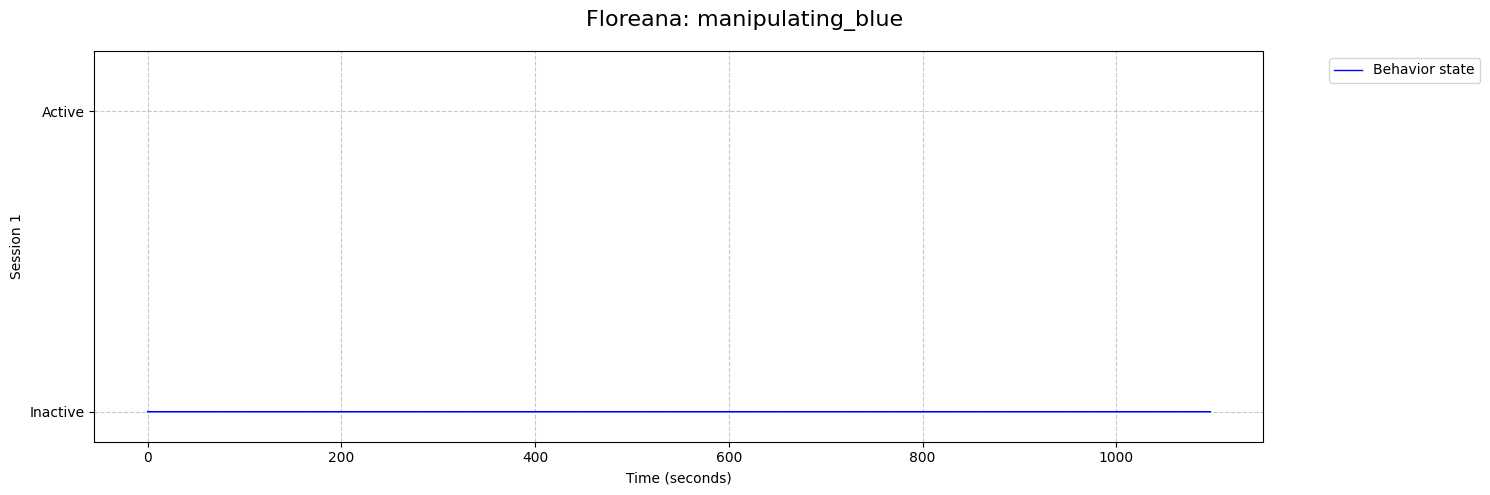

In [ ]:
def plot_behavior_array(behavior_tensor, subject, behavior, session=None):
    """
    Plot behavior with triangles indicating attempts, maintaining the nice visual style.
    """
    num_subjects, num_behaviors, num_sessions, session_length, _ = behavior_tensor.shape

    subject_idx = list(behavior_tensor.subjects).index(subject)
    behavior_idx = list(behavior_tensor.behaviors).index(behavior)

    if session is not None:
        session_idx = list(behavior_tensor.sessions).index(session)
        behavior_array = behavior_tensor[subject_idx, behavior_idx, session_idx, :, :].numpy()
        sessions_to_plot = [session]
    else:
        behavior_array = behavior_tensor[subject_idx, behavior_idx, :, :, :].numpy()
        sessions_to_plot = behavior_tensor.sessions

    if session is not None:
        fig, ax = plt.subplots(figsize=(15, 5))
        axes = [ax]
    else:
        fig, axes = plt.subplots(num_sessions, 1, figsize=(15, 3*num_sessions), sharex=True)
        if num_sessions == 1:
            axes = [axes]

    fig.suptitle(f"{subject.capitalize()}: {behavior}", fontsize=16)

    for i, (ax, session_array) in enumerate(zip(axes, behavior_array.reshape(-1, session_length, 3))):
        time_axis = np.arange(session_length)

        # Plot behavior state with nice blue shade
        ax.plot(time_axis, session_array[:, 0], linewidth=1, color='blue', label='Behavior state')
        ax.fill_between(time_axis, 0, session_array[:, 0], alpha=0.3, color='blue')

        # Plot attempts on top of the behavior state
        height = 1  # Height for both types of triangles

        # Plot successful and unsuccessful attempts
        success_times = np.where(session_array[:, 1] == 1)[0]
        failure_times = np.where(session_array[:, 2] == 1)[0]

        if len(success_times) > 0:
            ax.plot(success_times, np.ones_like(success_times) * height, '^',
                   color='blue', markersize=10, label='Successful attempts')

        if len(failure_times) > 0:
            ax.plot(failure_times, np.ones_like(failure_times) * height, 'v',
                   color='red', markersize=10, label='Unsuccessful attempts')

        ax.set_ylim(-0.1, 1.2)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Inactive', 'Active'])
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel(f"Session {sessions_to_plot[i]}")

        if i == 0:  # Only show legend for first subplot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        if i == len(sessions_to_plot) - 1:
            ax.set_xlabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_behavior_array(behavior_tensor, 'floreana', 'manipulating_blue', session=1)

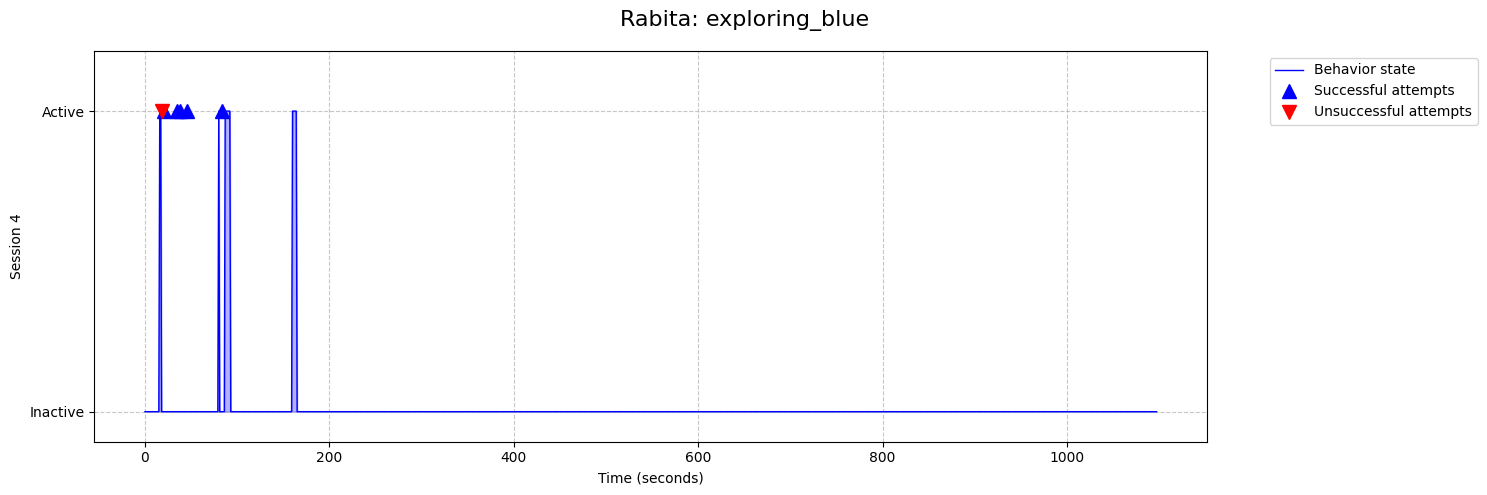

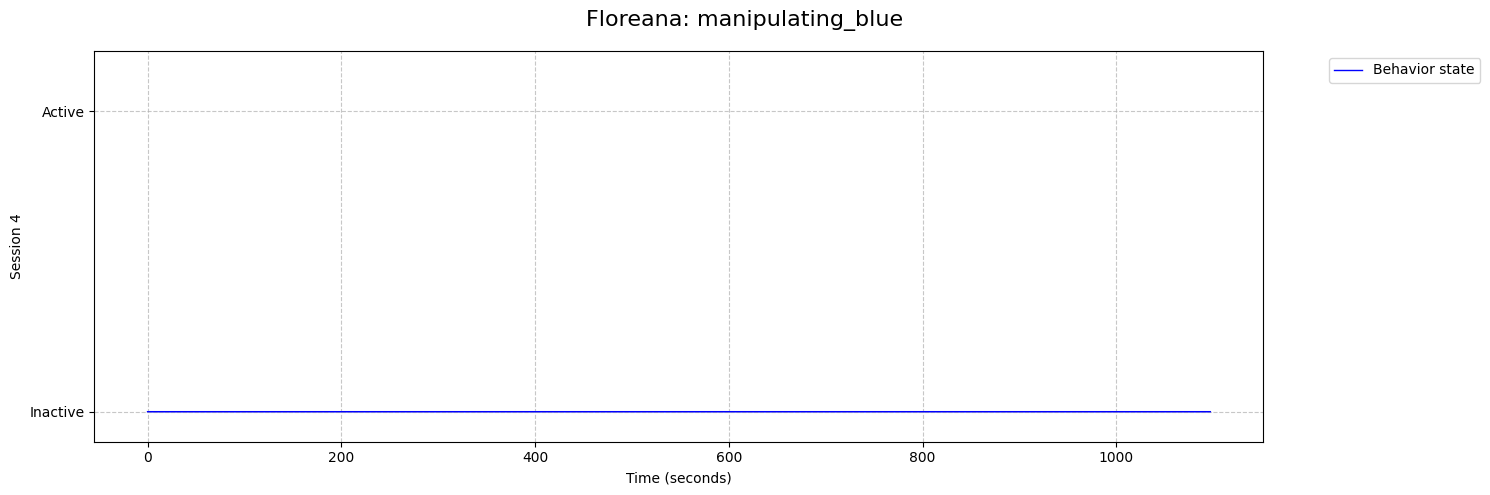

In [ ]:
behavior_to_plot1 = 'exploring_blue'
behavior_to_plot2 = 'manipulating_blue'
session_to_plot = 4

plot_behavior_array(behavior_tensor, 'rabita', behavior_to_plot1, session_to_plot)
plot_behavior_array(behavior_tensor, 'floreana', behavior_to_plot2, session_to_plot)


#Calculate transition probabilities

###Function for the Transition of one binary vector

In [ ]:
def compute_transition_probabilities(binary_array):
    """
    Compute transition probabilities for a binary array.
    Returns 2x2 transition matrix
    """
    # Convert to numpy if it's a tensor
    if isinstance(binary_array, torch.Tensor):
        binary_array = binary_array.numpy()

    # Count transitions
    transitions = np.zeros((2, 2))
    for i in range(len(binary_array) - 1):
        current_state = int(binary_array[i])
        next_state = int(binary_array[i + 1])
        transitions[current_state, next_state] += 1

    # Compute probabilities
    row_sums = transitions.sum(axis=1)

    # Handle cases where a state never occurs
    p00 = transitions[0, 0] / row_sums[0] if row_sums[0] > 0 else 0
    p11 = transitions[1, 1] / row_sums[1] if row_sums[1] > 0 else 0

    return torch.tensor([
        [p00, 1 - p00],
        [1 - p11, p11]
    ], dtype=torch.float32)

def get_transition_matrix(behavior_tensor, subject, behavior, session):
    """
    Get transition matrix for specific subject, behavior, and session.
    Handles the new tensor structure with attempt types.

    Args:
        behavior_tensor: The full behavior tensor with attributes subjects, behaviors, sessions
        subject: Name of the subject
        behavior: Name of the behavior
        session: Session number

    Returns:
        2x2 transition probability matrix
    """
    # Find indices
    subject_idx = list(behavior_tensor.subjects).index(subject)
    behavior_idx = list(behavior_tensor.behaviors).index(behavior)
    session_idx = list(behavior_tensor.sessions).index(session)

    # Get binary array for this combination, extracting behavior state
    binary_array = behavior_tensor[subject_idx, behavior_idx, session_idx, :, 0]

    # Compute and return transition matrix
    trans_matrix = compute_transition_probabilities(binary_array)

    # Print information
    print(f"\nTransition probabilities for {subject}, {behavior}, session {session}:")
    print("     0      1")
    print(f"0  {trans_matrix[0,0]:.3f}  {trans_matrix[0,1]:.3f}")
    print(f"1  {trans_matrix[1,0]:.3f}  {trans_matrix[1,1]:.3f}")

    return trans_matrix


###Subject and Behavior specific transition i.e. subject x's performing action y

In [ ]:
def analyze_session_transitions(behavior_tensor, subject, behavior):
    """
    Analyze transition probabilities across all sessions and compute differences
    between consecutive sessions.

    Args:
        behavior_tensor: The full behavior tensor with attributes subjects, behaviors, sessions
        subject: Name of the subject
        behavior: Name of the behavior

    Returns:
        List of transition matrices and list of difference matrices
    """
    # Get all sessions
    sessions = behavior_tensor.sessions

    # Store transition matrices for all sessions
    transition_matrices = []

    # Calculate transition matrices for all sessions
    print(f"\nAnalyzing transitions for {subject}, behavior: {behavior}")
    print("=" * 50)

    for session in sessions:
        trans_matrix = get_transition_matrix(behavior_tensor, subject, behavior, session)
        transition_matrices.append(trans_matrix)


    # Convert transition matrices to numpy for easier calculations
    matrices_np = np.array([m.numpy() for m in transition_matrices])

    # Calculate mean transition probabilities across sessions
    mean_matrix = np.mean(matrices_np, axis=0)
    print("\nMean transition probabilities across all sessions:")
    print("     0      1")
    print(f"0  {mean_matrix[0,0]:.3f}  {mean_matrix[0,1]:.3f}")
    print(f"1  {mean_matrix[1,0]:.3f}  {mean_matrix[1,1]:.3f}")

    # Calculate standard deviation of transition probabilities
    std_matrix = np.std(matrices_np, axis=0)
    print("\nStandard deviation of transition probabilities:")
    print("     0      1")
    print(f"0  {std_matrix[0,0]:.3f}  {std_matrix[0,1]:.3f}")
    print(f"1  {std_matrix[1,0]:.3f}  {std_matrix[1,1]:.3f}")

    return transition_matrices, mean_matrix

# Example usage:
matrices, mean_matrices = analyze_session_transitions(behavior_tensor, 'rabita', 'exploring_black')


print(matrices)


Analyzing transitions for rabita, behavior: exploring_black

Transition probabilities for rabita, exploring_black, session 1:
     0      1
0  0.994  0.006
1  0.085  0.915

Transition probabilities for rabita, exploring_black, session 2:
     0      1
0  0.997  0.003
1  0.250  0.750

Transition probabilities for rabita, exploring_black, session 3:
     0      1
0  0.998  0.002
1  0.158  0.842

Transition probabilities for rabita, exploring_black, session 4:
     0      1
0  0.998  0.002
1  0.222  0.778

Transition probabilities for rabita, exploring_black, session 5:
     0      1
0  0.997  0.003
1  0.300  0.700

Transition probabilities for rabita, exploring_black, session 6:
     0      1
0  0.995  0.005
1  0.500  0.500

Transition probabilities for rabita, exploring_black, session 7:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, exploring_black, session 8:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, explo

###Subject specific transitions i.e. all subject x's transitions

In [ ]:
def analyze_behaviors(subject_name, behavior_tensor):
    """
    Analyze mean transition probabilities for different behaviors across colors.

    Parameters:
    -----------
    subject_name : str
        Name of the subject to analyze
    behavior_tensor : tensor-like
        Behavior data tensor containing session information

    Returns:
    --------
    dict
        Dictionary containing mean transition matrices for each behavior type
    """
    # Define colors and behavior types
    colors = ['black', 'blue', 'red', 'nocolor']
    behaviors = ['exploring', 'manipulating']

    # Initialize results dictionary
    results = {}

    # Process each behavior type
    for behavior in behaviors:
        # Process each color
        for color in colors:
            behavior_name = f"{behavior}_{color}"

            # Get transition matrices and mean matrix for current behavior
            _, mean_matrix = analyze_session_transitions(
                behavior_tensor,
                subject=subject_name,
                behavior=behavior_name
            )

            # Store result (only the mean matrix)
            results[behavior_name] = mean_matrix

    # Create formatted output
    def format_matrix_table(matrix_dict):
        """Helper function to format mean transition matrices into tables"""
        tables = {}
        for behavior, matrix in matrix_dict.items():
            # Create DataFrame with proper labels
            df = pd.DataFrame(
                matrix,
                index=['No behavior', 'Behavior'],
                columns=['No behavior', 'Behavior']
            )
            table = tabulate(df, headers='keys', tablefmt='grid',
                           floatfmt='.3f', showindex=True)
            tables[behavior] = table
        return tables

    # Format all matrices
    formatted_tables = format_matrix_table(results)

    # Print results
    print(f"\nMean Transition Probability Matrices for Subject: {subject_name}")
    print("=" * 60)

    for behavior, table in formatted_tables.items():
        print(f"\nBehavior: {behavior}")
        print("-" * 40)
        print(table)
        print()  # Single line break between matrices

    return results

# Example usage:
mean_matrices = analyze_behaviors('rabita', behavior_tensor)


Analyzing transitions for rabita, behavior: exploring_black

Transition probabilities for rabita, exploring_black, session 1:
     0      1
0  0.994  0.006
1  0.085  0.915

Transition probabilities for rabita, exploring_black, session 2:
     0      1
0  0.997  0.003
1  0.250  0.750

Transition probabilities for rabita, exploring_black, session 3:
     0      1
0  0.998  0.002
1  0.158  0.842

Transition probabilities for rabita, exploring_black, session 4:
     0      1
0  0.998  0.002
1  0.222  0.778

Transition probabilities for rabita, exploring_black, session 5:
     0      1
0  0.997  0.003
1  0.300  0.700

Transition probabilities for rabita, exploring_black, session 6:
     0      1
0  0.995  0.005
1  0.500  0.500

Transition probabilities for rabita, exploring_black, session 7:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, exploring_black, session 8:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, explo

###Save transition probabilities of one subject in an Excel file

In [ ]:
def export_transitions_to_excel(subject_name, behavior_tensor, filename=None):
    """
    Export transition matrices to an organized Excel file with grouped data.
    Exploring and Manipulating data are displayed side by side.
    """
    if filename is None:
        # Create path if it doesn't exist
        import os
        save_dir = "/root/Subjectname_Transitions"
        os.makedirs(save_dir, exist_ok=True)

        # Create filename using subject name
        filename = os.path.join(save_dir, f"{subject_name}_transitions.xlsx")

    # Create workbook and select active sheet
    wb = Workbook()
    ws = wb.active
    ws.title = "Transition Matrices"

    # Styles
    header_fill = PatternFill(start_color="CCE5FF", end_color="CCE5FF", fill_type="solid")
    subheader_fill = PatternFill(start_color="E6F2FF", end_color="E6F2FF", fill_type="solid")
    border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    # Write title
    ws['A1'] = f"Transition Matrices Analysis for Subject: {subject_name}"
    ws.merge_cells('A1:O1')
    ws['A1'].font = Font(bold=True, size=14)
    ws['A1'].alignment = Alignment(horizontal='center')

    # Current row tracker
    current_row = 3

    # Write behavior headers side by side
    ws.cell(row=current_row, column=2, value="EXPLORING")
    ws.merge_cells(f'B{current_row}:G{current_row}')
    ws.cell(row=current_row, column=9, value="MANIPULATING")
    ws.merge_cells(f'I{current_row}:N{current_row}')

    for col in range(2, 15):
        if col in range(2, 8) or col in range(9, 15):
            ws.cell(row=current_row, column=col).fill = header_fill
            ws.cell(row=current_row, column=col).border = border
            ws.cell(row=current_row, column=col).font = Font(bold=True)

    current_row += 1

    # Process colors (now side by side for exploring and manipulating)
    colors = ['black', 'blue', 'red', 'nocolor']
    start_color_row = current_row

    for color in colors:
        # Process exploring
        behavior_name = f"exploring_{color}"
        transition_matrices, mean_matrix = analyze_session_transitions(
            behavior_tensor,
            subject=subject_name,
            behavior=behavior_name
        )

        # Write color header for exploring
        ws.cell(row=current_row, column=2, value=f"{color}")
        ws.merge_cells(f'B{current_row}:G{current_row}')
        for col in range(2, 8):
            ws.cell(row=current_row, column=col).fill = subheader_fill
            ws.cell(row=current_row, column=col).border = border

        # Process manipulating (same color)
        behavior_name = f"manipulating_{color}"
        manip_matrices, manip_mean_matrix = analyze_session_transitions(
            behavior_tensor,
            subject=subject_name,
            behavior=behavior_name
        )

        # Write color header for manipulating
        ws.cell(row=current_row, column=9, value=f"{color}")
        ws.merge_cells(f'I{current_row}:N{current_row}')
        for col in range(9, 15):
            ws.cell(row=current_row, column=col).fill = subheader_fill
            ws.cell(row=current_row, column=col).border = border
        current_row += 1

        # Write headers for both sides
        for col_offset, label in [(0, "To: No Behavior"), (1, "To: Behavior")]:
            ws.cell(row=current_row, column=3 + col_offset, value=label)
            ws.cell(row=current_row, column=10 + col_offset, value=label)
        current_row += 1

        # Write mean matrix values for both sides
        for i, label in enumerate(["From: No Behavior", "From: Behavior"]):
            ws.cell(row=current_row + i, column=2, value=label)
            ws.cell(row=current_row + i, column=3, value=float(mean_matrix[i,0]))
            ws.cell(row=current_row + i, column=4, value=float(mean_matrix[i,1]))

            ws.cell(row=current_row + i, column=9, value=label)
            ws.cell(row=current_row + i, column=10, value=float(manip_mean_matrix[i,0]))
            ws.cell(row=current_row + i, column=11, value=float(manip_mean_matrix[i,1]))

        current_row += 2

        # Add session details in grouped rows (exploring)
        session_start_row = current_row
        ws.cell(row=current_row, column=2, value="Session Details")
        current_row += 1

        for session, matrix in zip(behavior_tensor.sessions, transition_matrices):
            ws.cell(row=current_row, column=2, value=f"Session {session}")
            ws.cell(row=current_row, column=3, value=float(matrix[0,0]))
            ws.cell(row=current_row, column=4, value=float(matrix[0,1]))
            current_row += 1
            ws.cell(row=current_row, column=3, value=float(matrix[1,0]))
            ws.cell(row=current_row, column=4, value=float(matrix[1,1]))
            current_row += 1

        exploring_end_row = current_row - 1
        current_row = session_start_row

        # Add session details for manipulating (aligned with exploring)
        ws.cell(row=current_row, column=9, value="Session Details")
        current_row += 1

        for session, matrix in zip(behavior_tensor.sessions, manip_matrices):
            ws.cell(row=current_row, column=9, value=f"Session {session}")
            ws.cell(row=current_row, column=10, value=float(matrix[0,0]))
            ws.cell(row=current_row, column=11, value=float(matrix[0,1]))
            current_row += 1
            ws.cell(row=current_row, column=10, value=float(matrix[1,0]))
            ws.cell(row=current_row, column=11, value=float(matrix[1,1]))
            current_row += 1

        # Group session details for both sides
        ws.row_dimensions.group(session_start_row, exploring_end_row, hidden=True)

        current_row += 2  # Add space between colors

    # Format cells
    for row in ws.iter_rows(min_row=1, max_row=current_row-1):
        for cell in row:
            if isinstance(cell.value, float):
                cell.number_format = '0.000'
            cell.alignment = Alignment(horizontal='center')

    # Adjust column widths
    for col in ws.columns:
        max_length = 0
        column = get_column_letter(col[0].column)
        for cell in col:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width

    # Add conditional formatting for transition probabilities
    color_scale = ColorScale(
        cfvo=[FormatObject(type='num', val=0),
              FormatObject(type='num', val=0.5),
              FormatObject(type='num', val=1)],
        color=[('F8696B'),
               ('FFEB84'),
               ('63BE7B')]
    )
    rule = Rule(type='colorScale', colorScale=color_scale)
    ws.conditional_formatting.add('C4:D100', rule)  # Exploring probabilities
    ws.conditional_formatting.add('J4:K100', rule)  # Manipulating probabilities

    # Save workbook
    wb.save(filename)
    print(f"Excel file saved as: {filename}")

    return filename

# Example usage:
filename = export_transitions_to_excel('rabita', behavior_tensor)


Analyzing transitions for rabita, behavior: exploring_black

Transition probabilities for rabita, exploring_black, session 1:
     0      1
0  0.994  0.006
1  0.085  0.915

Transition probabilities for rabita, exploring_black, session 2:
     0      1
0  0.997  0.003
1  0.250  0.750

Transition probabilities for rabita, exploring_black, session 3:
     0      1
0  0.998  0.002
1  0.158  0.842

Transition probabilities for rabita, exploring_black, session 4:
     0      1
0  0.998  0.002
1  0.222  0.778

Transition probabilities for rabita, exploring_black, session 5:
     0      1
0  0.997  0.003
1  0.300  0.700

Transition probabilities for rabita, exploring_black, session 6:
     0      1
0  0.995  0.005
1  0.500  0.500

Transition probabilities for rabita, exploring_black, session 7:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, exploring_black, session 8:
     0      1
0  0.998  0.002
1  0.286  0.714

Transition probabilities for rabita, explo

# Calculate Success rate and perform success rate plot

In [ ]:
def calculate_success_rates(df):
    """
    Calculate success rates per session for each subject.
    Returns numpy arrays for rates and attempts, properly indexed.
    """
    # Get unique subjects and sessions, ensure they're sorted
    subjects = np.sort(df['subject'].unique())
    sessions = np.sort(df['session'].unique())

    # Initialize arrays
    n_subjects = len(subjects)
    n_sessions = len(sessions)

    success_rates = np.full((n_subjects, n_sessions), np.nan)
    success_counts = np.zeros((n_subjects, n_sessions), dtype=int)
    total_attempts = np.zeros((n_subjects, n_sessions), dtype=int)

    # Calculate rates for each subject and session
    for i, subject in enumerate(subjects):
        for j, session in enumerate(sessions):
            # Get attempts for this subject and session
            attempts = df[(df['subject'] == subject) &
                        (df['session'] == session) &
                        (df['behavior type'] == 'POINT')]

            if len(attempts) > 0:
                successes = len(attempts[attempts['behavior'] == 'successful'])
                total = len(attempts)

                success_rates[i, j] = successes / total
                success_counts[i, j] = successes
                total_attempts[i, j] = total

    return {
        'rates': success_rates,
        'successes': success_counts,
        'attempts': total_attempts,
        'subjects': subjects,
        'sessions': sessions
    }

def plot_success_rates(data_dict):
    """
    Plot success rates using the stored arrays.
    """
    success_rates = data_dict['rates']
    subjects = data_dict['subjects']
    sessions = data_dict['sessions']
    attempts = data_dict['attempts']

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(subjects)))

    for i, (subject, color) in enumerate(zip(subjects, colors)):
        rates = success_rates[i]
        subj_attempts = attempts[i]

        # Plot line
        plt.plot(sessions, rates, '-', color=color, alpha=0.7, label=subject)

        # Plot points with size proportional to attempts
        sizes = 50 * (subj_attempts + 1)  # Add 1 to ensure visible even with 0 attempts
        plt.scatter(sessions, rates, s=sizes, color=color, alpha=0.6)

    plt.xlabel('Session')
    plt.ylabel('Success Rate')
    plt.title('Success Rates Across Sessions by Subject\n(Point size indicates number of attempts)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.ylim(-0.05, 1.05)
    plt.xticks(sessions, rotation=45)

    # Reference lines
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)

    plt.tight_layout()
    return plt.gcf()

def print_summary(data_dict):
    """
    Print summary statistics from the stored arrays.
    """
    rates = data_dict['rates']
    successes = data_dict['successes']
    attempts = data_dict['attempts']
    subjects = data_dict['subjects']
    sessions = data_dict['sessions']

    print("\nSuccess Rate Summary")
    print("=" * 60)

    for i, subject in enumerate(subjects):
        print(f"\n{subject.upper()}")
        print("-" * 60)
        print(f"{'Session':<8} {'Success Rate':<12} {'Successes':<10} {'Attempts':<8}")
        print("-" * 60)

        for j, session in enumerate(sessions):
            rate = rates[i, j]
            if np.isnan(rate):
                rate_str = "No attempts"
            else:
                rate_str = f"{rate:.1%}"

            print(f"{session:<8} {rate_str:>11} {successes[i,j]:>10} {attempts[i,j]:>8}")

        # Calculate subject overall stats
        valid_sessions = ~np.isnan(rates[i])
        if np.any(valid_sessions):
            overall_rate = np.nanmean(rates[i])
            total_succ = np.sum(successes[i])
            total_att = np.sum(attempts[i])
            print("-" * 60)
            print(f"Overall: {overall_rate:.1%} {total_succ:>10} {total_att:>8}")

# Example usage:
data = calculate_success_rates(df)



Success Rate Summary

FLOREANA
------------------------------------------------------------
Session  Success Rate Successes  Attempts
------------------------------------------------------------
1        No attempts          0        0
2        No attempts          0        0
3        No attempts          0        0
4        No attempts          0        0
5        No attempts          0        0
6        No attempts          0        0
7        No attempts          0        0
8        No attempts          0        0
9        No attempts          0        0
10       No attempts          0        0

GENOVESA
------------------------------------------------------------
Session  Success Rate Successes  Attempts
------------------------------------------------------------
1              33.3%          3        9
2               0.0%          0        3
3               0.0%          0        4
4              80.0%          8       10
5              50.0%          2        4
6              

In [ ]:
# Print summary
print_summary(data)

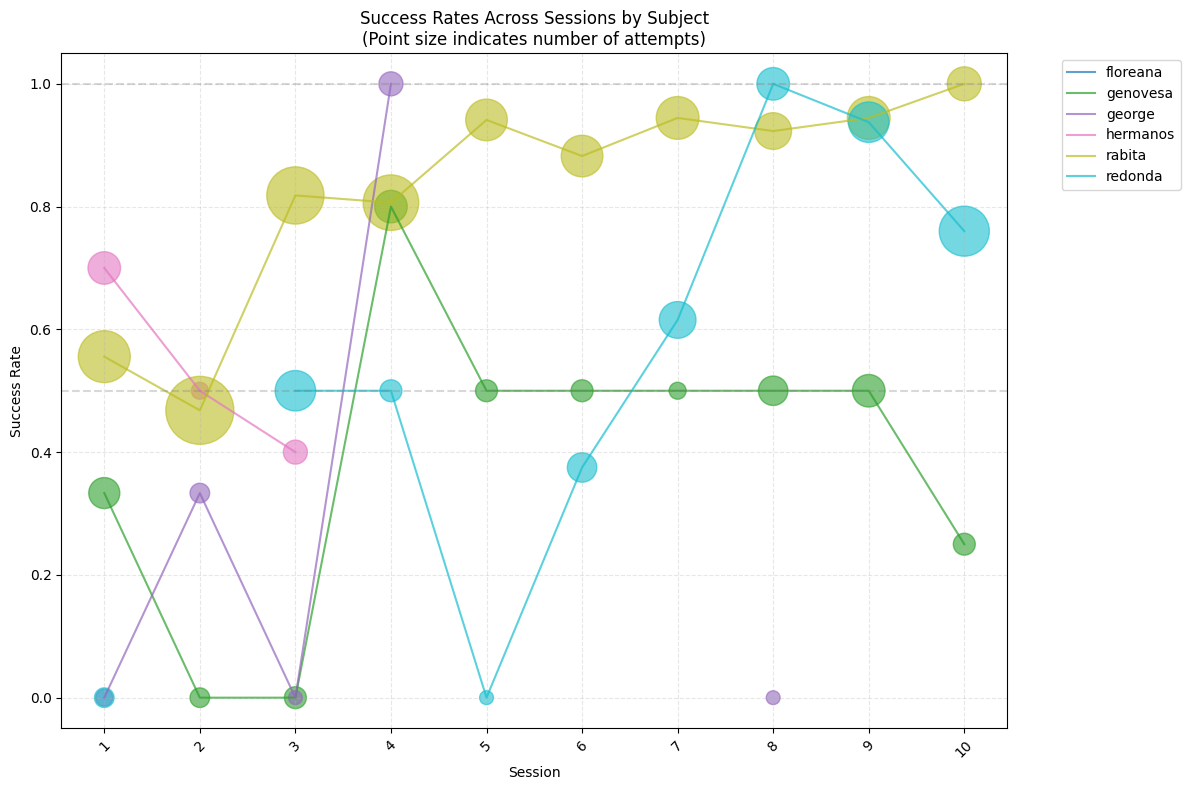

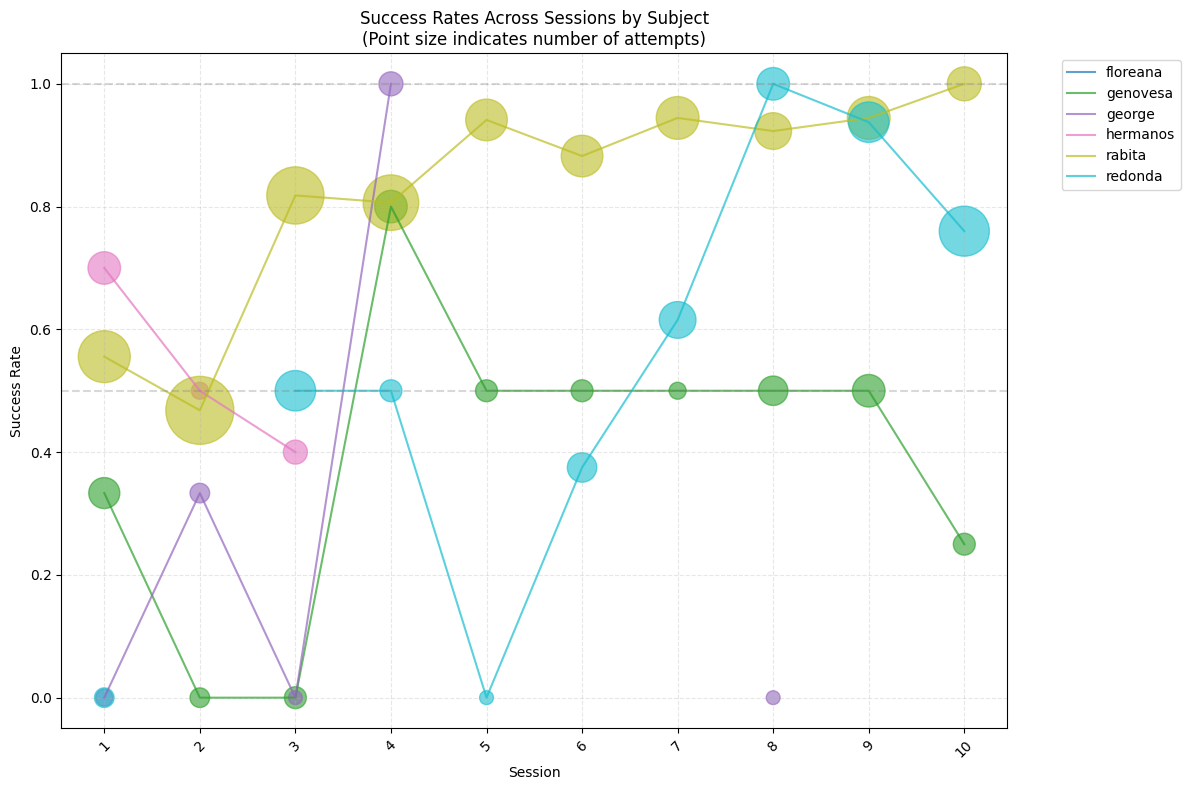

In [ ]:
# Create visualization
plot_success_rates(data)